In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# K Means Cluster - DGI Embeddings 
Cluster the NAICS embeddings from the DGI embeddings (base features). Compare this clustering to the default NAICS code clusters on these embeddings

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
from pathlib import Path

In [5]:
import sklearn as sk
from sklearn.cluster import KMeans

In [6]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [7]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import importlib

In [8]:
from sba_gnn.sba_gnn import sg_plot, sg_embed

In [9]:
sg_plot.plot_defaults()

## Import Data

##### Embeddings

In [10]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('31_DATA_embeddings.parquet')) 

In [11]:
emb_feat = [c for c in embed_df.columns if c.startswith('emb_')]

In [12]:
naics_map = pd.read_parquet(Path(setup.temp_path).joinpath('60_DATA_naics_map.parquet'))

In [13]:
one_hot_feat = naics_map[naics_map['NAICS_sector_sel'] == 1] \
    ['NAICS_sector'] \
    .drop_duplicates() \
    .to_list()
one_hot_feat_len = len(one_hot_feat) + 1
one_hot_feat_len

10

In [14]:
naics_info = pd.read_parquet(Path(setup.temp_path).joinpath('60_DATA_naics_summary_stats.parquet')) 

## Get TSNE Values

In [15]:
tsne_df = pd.concat([sg_embed.emb_tsne_transform(embed_df[emb_feat]), embed_df['NAICS_orig']], axis=1)

## NAICS Sector "Clusters"
Get the silhouette score for the base naics

##### Merge NAICS info into embeddings

In [16]:
embed_df['NAICS_2'] = embed_df['NAICS_orig'].str[0:2]
embed_df = embed_df.drop(columns=['NAICS_sector', 'NAICS_sector_sel',
                                  'NAICS_sector_desc', 'NAICS_sector_comb', 'train_count'], 
                         errors='ignore') \
    .merge(naics_map[['NAICS_2', 'NAICS_sector', 'NAICS_sector_sel', 'NAICS_sector_desc', 'NAICS_sector_comb']], how='left') \
    .merge(naics_info.rename(columns={'NAICS':'NAICS_orig'})[['NAICS_orig', 'train_count']],
           on='NAICS_orig', how='left')

In [17]:
embed_df['NAICS_sector_filt'] = np.where(embed_df['NAICS_sector_sel'] == 0, 'Other',
                                         embed_df['NAICS_sector_comb'])
embed_df['NAICS_sector_filt'] = embed_df['NAICS_sector_filt'].astype('category')

In [18]:
embed_df['NAICS_sector_comb'] = embed_df['NAICS_sector_comb'].astype('category')

In [19]:
embed_train_df = embed_df[embed_df['train_count'] > 0]

In [20]:
tsne_df = tsne_df.drop(columns=['all_target_mean', 'menc_NAICS'], errors='ignore') \
    .merge(naics_info.rename(columns={'NAICS':'NAICS_orig'}) \
                                [['NAICS_orig', 'all_target_mean', 'menc_NAICS']],
                              how='left', on='NAICS_orig')

In [21]:
tsne_train_df = tsne_df[tsne_df['NAICS_orig'].isin(embed_train_df['NAICS_orig'])]

In [22]:
naics_silhouette = silhouette_score(embed_df[emb_feat], embed_df['NAICS_sector_comb'])
naics_silhouette_values = silhouette_samples(embed_df[emb_feat], embed_df['NAICS_sector_comb'])

In [23]:
naics_silhouette

-0.1820822

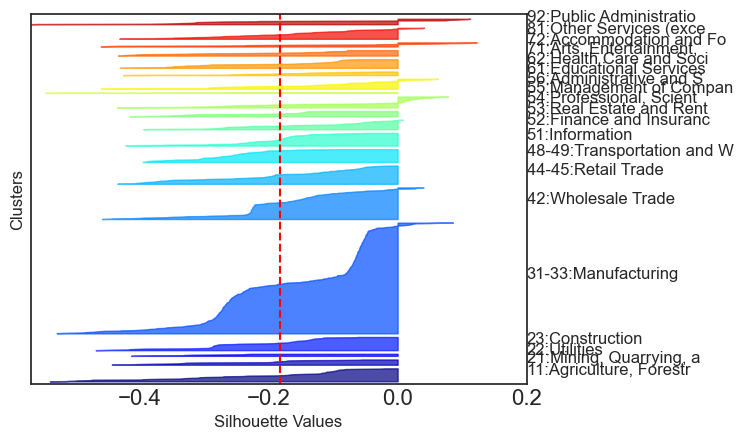

In [24]:
sg_embed.plot_silhouette(naics_silhouette_values, embed_df['NAICS_sector_comb'].to_numpy(),
                        label_x_pos = 1, cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_silhouette_base_naics_all.png'),
                 bbox_inches='tight') 

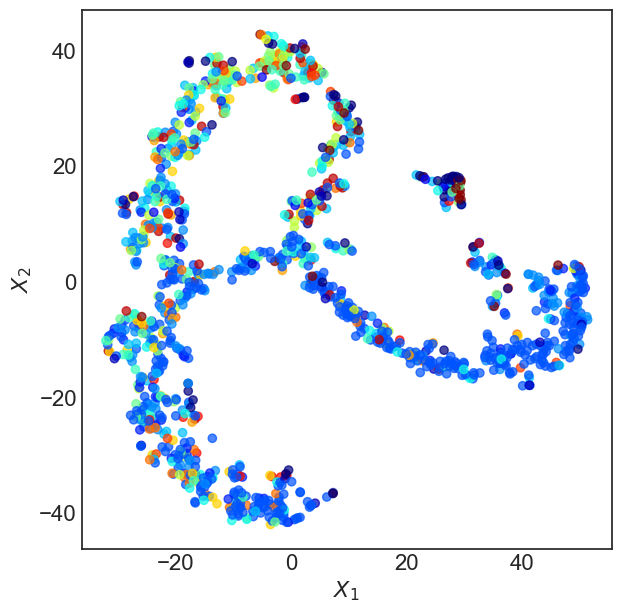

In [25]:
sg_embed.plot_clusters(tsne_df, embed_df['NAICS_sector_comb'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_base_naics_all.png'),
                 bbox_inches='tight') 

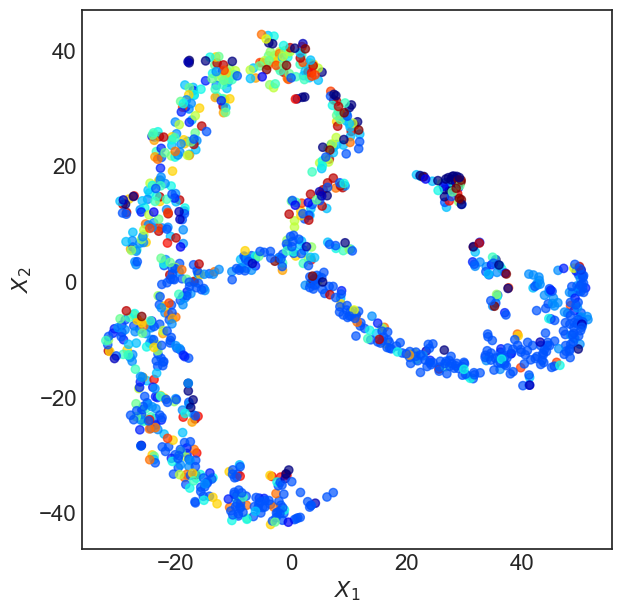

In [26]:
# Plot only on train data
sg_embed.plot_clusters(tsne_train_df, embed_train_df['NAICS_sector_comb'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_base_naics_train.png'),
                 bbox_inches='tight') 

## NAICS Sectors - Used in One Hot Only
Get the silhouette scores for the NAICS groups used in the one hot encoder (top 8 levels plus "other")

In [27]:
naics_silhouette_sel = silhouette_score(embed_df[emb_feat], embed_df['NAICS_sector_filt'])
naics_silhouette_values_sel = silhouette_samples(embed_df[emb_feat], embed_df['NAICS_sector_filt'])

In [28]:
naics_silhouette_sel

-0.14470285

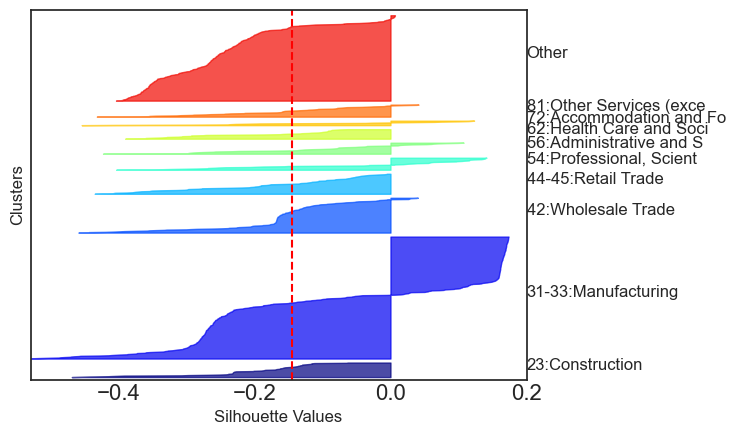

In [29]:
sg_embed.plot_silhouette(naics_silhouette_values_sel, embed_df['NAICS_sector_filt'].to_numpy(),
                        label_x_pos = 1, cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_silhouette_base_naics_sel.png'),
                 bbox_inches='tight') 

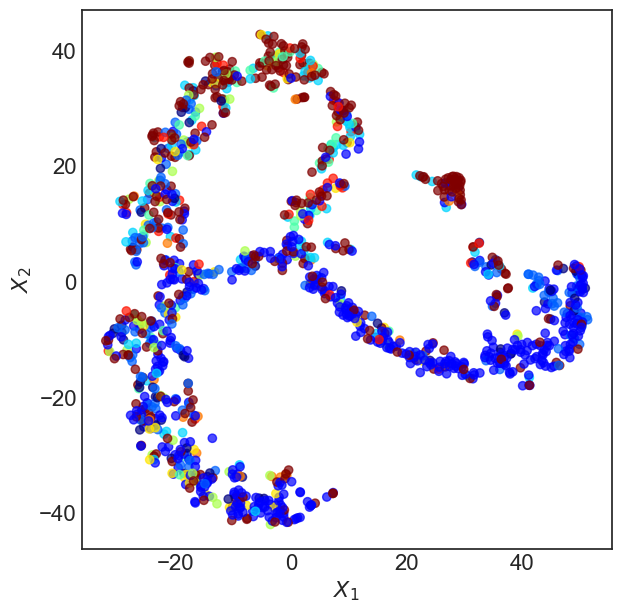

In [30]:
sg_embed.plot_clusters(tsne_df, embed_df['NAICS_sector_filt'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_base_naics_sel.png'),
                 bbox_inches='tight') 

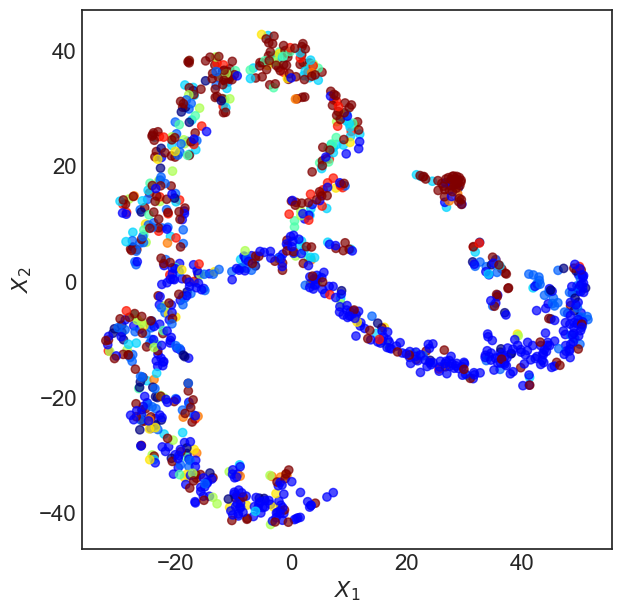

In [31]:
# Plot only on train data
sg_embed.plot_clusters(tsne_train_df, embed_train_df['NAICS_sector_filt'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_base_naics_sel_train.png'),
                 bbox_inches='tight') 

##### Save the silhouette scores

In [32]:
naics_silhouette_df = pd.DataFrame({'type':['all', 'sel'], 
                                    'score':[naics_silhouette, naics_silhouette_sel]})
naics_silhouette_df.to_csv(Path(setup.temp_path).joinpath('63_REPORT_naics_silhouette_mean.csv'))
naics_silhouette_df

,type,score
0,all,-0.182082
1,sel,-0.144703


## TSNE Plots By Target Rate

In [33]:
tsne_df.head()

,0,1,NAICS_orig,all_target_mean,menc_NAICS
0,3.475946,3.795208,722410,0.142825,0.141777
1,28.957125,-14.974748,332721,0.059633,0.064935
2,-0.513782,11.241294,445299,0.287306,0.204655
3,3.285417,11.519951,441120,0.240735,0.245432
4,9.740286,24.149925,512110,0.190087,0.204655


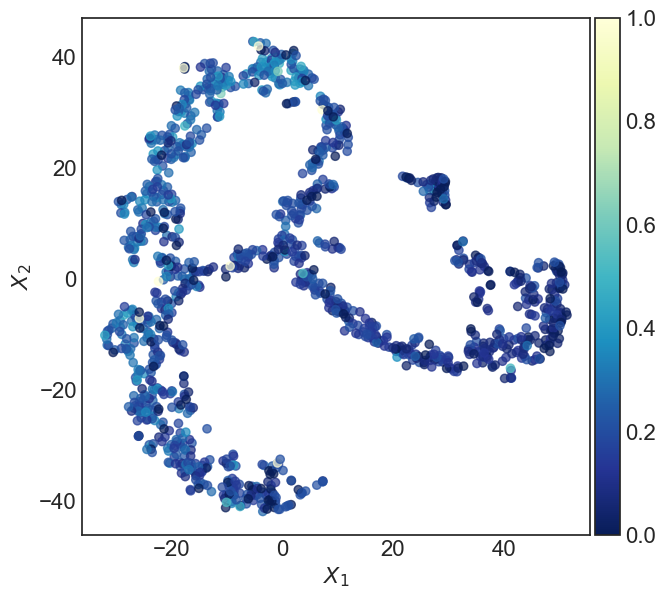

In [34]:
sg_embed.plot_clusters(tsne_df, tsne_df['menc_NAICS'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), colorbar = True)
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_naics_menc.png'),
                bbox_inches='tight') 

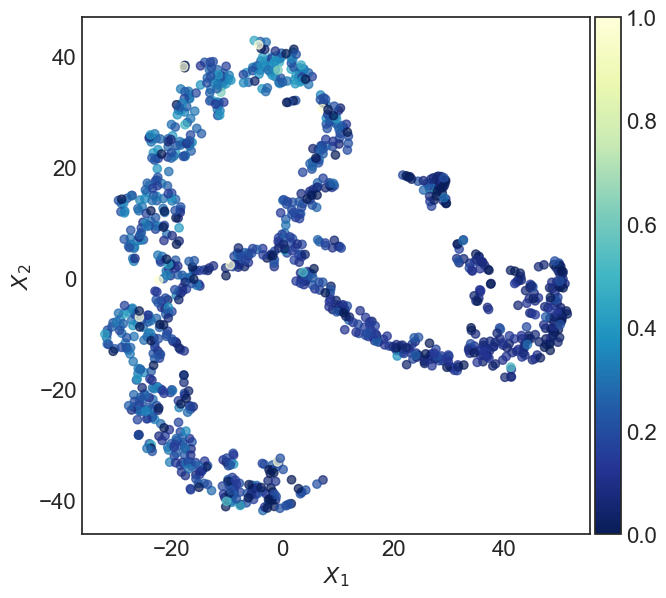

In [35]:
# train only
sg_embed.plot_clusters(tsne_train_df, tsne_train_df['menc_NAICS'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), colorbar = True)
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_naics_menc_train.png'),
                bbox_inches='tight') 

In [36]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

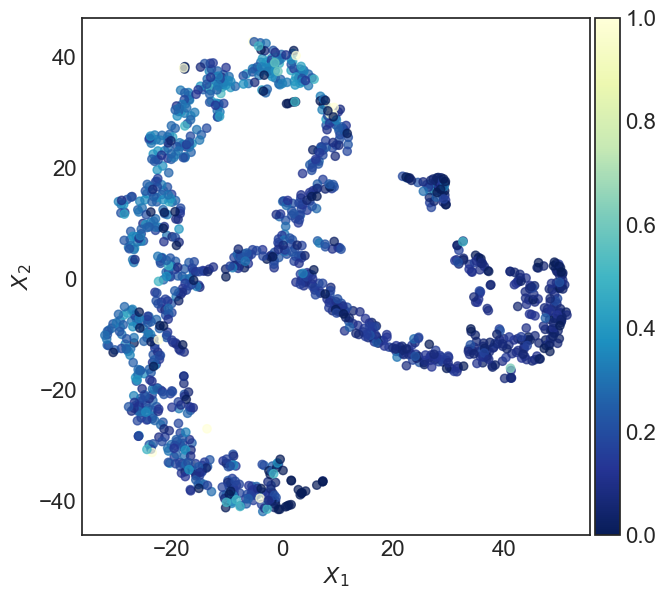

In [37]:
sg_embed.plot_clusters(tsne_df, tsne_df['all_target_mean'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), 
                       colorbar = True, aspect='equal')
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_naics_mean.png'),
                 bbox_inches='tight') 

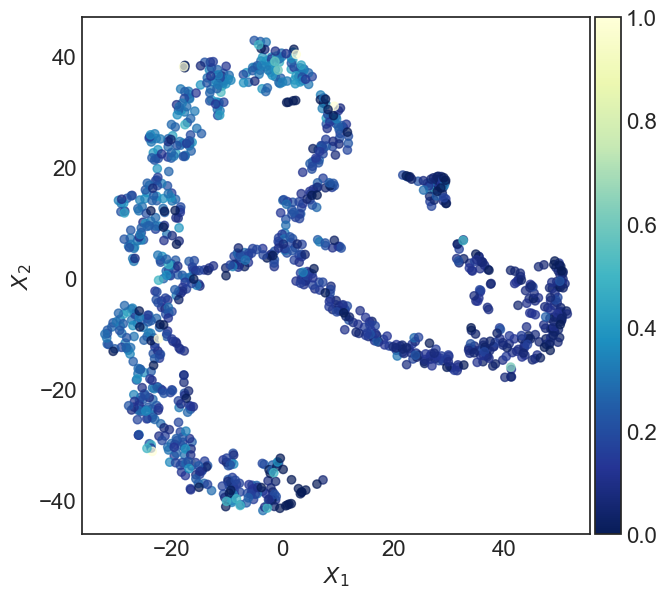

In [38]:
# Train only
sg_embed.plot_clusters(tsne_train_df, tsne_train_df['all_target_mean'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), 
                       colorbar = True, aspect='equal')
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_naics_mean.png'),
                 bbox_inches='tight') 

## K Means Loop
Get silhouette scores and cluster info for a variety of counts.  Plot the best score, as well as the selected size.  We can use all data, as we have features for all 

Also add in a larger size (80) for hierarchical clustering later

In [60]:
range_n_clusters = [n for n in np.arange(2, 25)] + [80]

In [61]:
all_silhouette_summary = pd.DataFrame()
all_cluster_labels = pd.DataFrame()
all_cluster_centers = pd.DataFrame()
all_silhouette_values = pd.DataFrame()

for n_clusters in range_n_clusters:
    
    # Get the kmeans information
    cluster_labels, cluster_centers, silhouette_avg, sample_silhouette_values = \
        sg_embed.get_clusters_silhouettes(embed_df[emb_feat], n_clusters)
        
    # Save silhouette summary
    all_silhouette_summary = pd.concat([all_silhouette_summary, 
                                        pd.DataFrame({'n_clusters': [n_clusters],
                                                      'silhouette_avg':[silhouette_avg]})])
    
    # Save silhouette values
    sample_silhouette_df = pd.DataFrame(sample_silhouette_values, columns=['value'],
                                       index = embed_df.index)
    sample_silhouette_df['n_clusters'] = n_clusters
    sample_silhouette_df.set_index('n_clusters', append=True,  inplace=True)
    all_silhouette_values = pd.concat([all_silhouette_values, sample_silhouette_df])
    
    # Save cluster labels
    cluster_df = pd.DataFrame(cluster_labels, columns=['label'], index=embed_df.index)
    cluster_df['n_clusters'] = n_clusters
    cluster_df.set_index('n_clusters', append=True,  inplace=True)
    all_cluster_labels = pd.concat([all_cluster_labels, cluster_df])
    
    # Save cluster centers
    cluster_centers_df = pd.DataFrame(cluster_centers)
    cluster_centers_df['n_clusters'] = n_clusters
    cluster_centers_df.set_index('n_clusters', append=True, inplace=True)
    all_cluster_centers = pd.concat([all_cluster_centers, cluster_centers_df])

In [62]:
all_silhouette_values.reset_index(level=1, inplace=True)
all_cluster_labels.reset_index(level=1, inplace=True)
all_cluster_centers.reset_index(level=1, inplace=True)

In [63]:
all_silhouette_values.to_parquet(Path(setup.temp_path).joinpath('63_DATA_loop_silhouette_values.parquet'))
all_silhouette_summary.to_csv(Path(setup.temp_path).joinpath('63_DATA_loop_silhouette_summary.csv'))

In [64]:
all_cluster_labels.to_parquet(Path(setup.temp_path).joinpath('63_DATA_loop_cluster_labels.parquet'))

In [65]:
all_cluster_centers.columns = [str(c) for c in all_cluster_centers.columns]
all_cluster_centers.to_parquet(Path(setup.temp_path).joinpath('63_DATA_loop_cluster_centers.parquet'))

##### Get the clusters with the best silhouette score

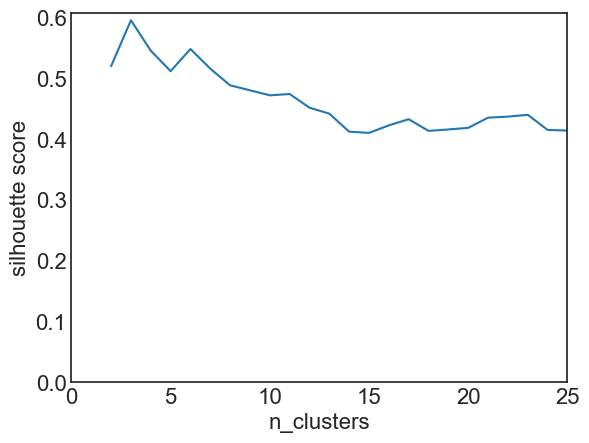

In [68]:
all_silhouette_summary.plot(x='n_clusters', y='silhouette_avg', legend=None)
plt.ylim(bottom=0)
plt.xlim([0,25])
plt.ylabel('silhouette score')
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_silhouette_summary.png'),
                 bbox_inches='tight') 
all_silhouette_summary.to_csv(Path(setup.temp_path).joinpath('63_REPORT_loop_silhouette_summary.csv'))

In [69]:
best_clus = all_silhouette_summary.sort_values('silhouette_avg', ascending=False)['n_clusters'].iloc[0]
best_clus

3

## Plots for Best Score Clusters

In [70]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

In [71]:
best_values = all_silhouette_values[all_silhouette_values['n_clusters'] == best_clus] \
    .drop(columns='n_clusters')
best_labels= all_cluster_labels[all_cluster_labels['n_clusters'] == best_clus] \
     .drop(columns='n_clusters')  

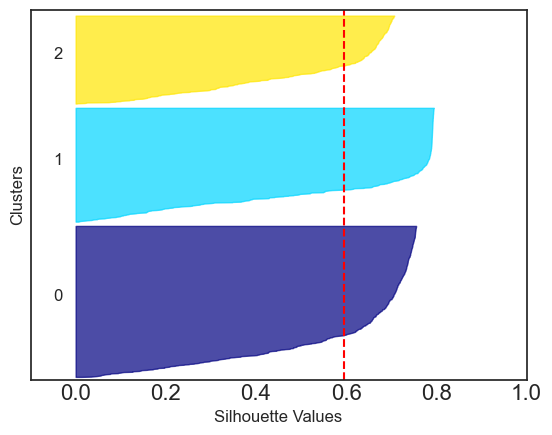

In [72]:
sg_embed.plot_silhouette(best_values.to_numpy(), best_labels.to_numpy(),
                        cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_silhouette_best.png'),
                 bbox_inches='tight') 

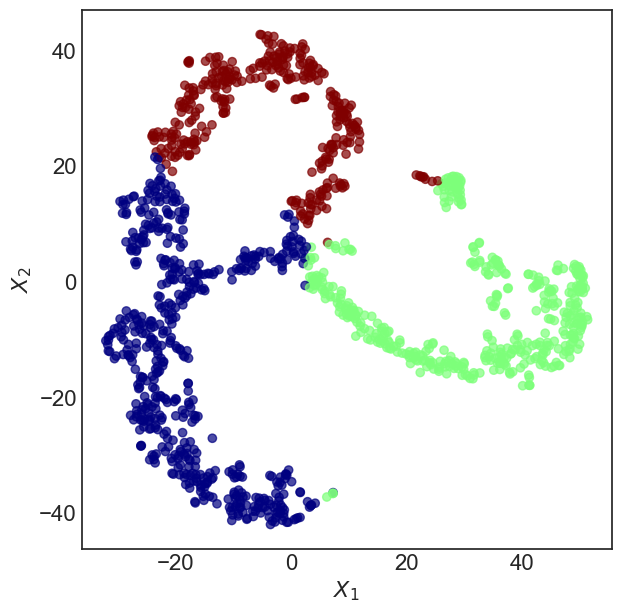

In [73]:
sg_embed.plot_clusters(tsne_df, best_labels['label'],
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_clusters_best.png'),
                 bbox_inches='tight') 

## Plots for Selected Length
Use the same number of levels as we have from the original one hot encoding

In [74]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

In [75]:
sel_values = all_silhouette_values[all_silhouette_values['n_clusters'] == one_hot_feat_len] \
    .drop(columns='n_clusters')
sel_labels= all_cluster_labels[all_cluster_labels['n_clusters'] == one_hot_feat_len] \
     .drop(columns='n_clusters')  

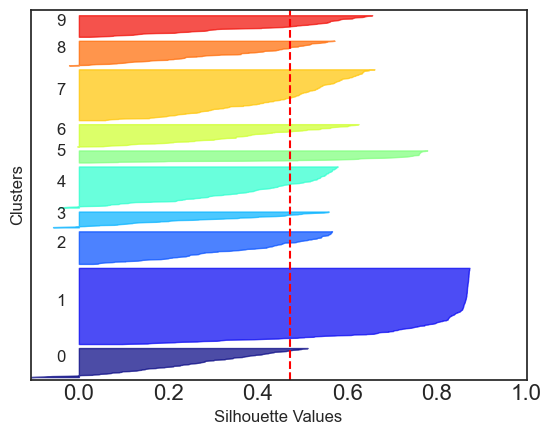

In [76]:
sg_embed.plot_silhouette(sel_values.to_numpy(), sel_labels.to_numpy(),
                        cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_silhouette_selected.png'),
                 bbox_inches='tight') 

In [77]:
np.max(sel_values.to_numpy())

0.8725129

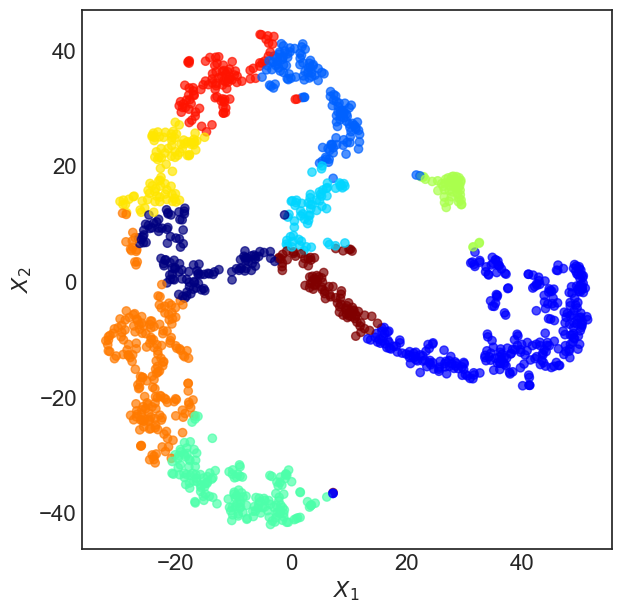

In [78]:
sg_embed.plot_clusters(tsne_df, sel_labels['label'],
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_clusters_selected.png'),
                 bbox_inches='tight') 

## Save the embeddings with TSNE and Cluster Info
Include one hot encodings, selected clusters and the clusters for hierarchical mean encoding (20 and 80)

##### Cluster labels for hiearchical blending

In [80]:
sel_labels_20 = all_cluster_labels[all_cluster_labels['n_clusters'] == 20] \
     .drop(columns='n_clusters')
sel_labels_80 = all_cluster_labels[all_cluster_labels['n_clusters'] == 80] \
     .drop(columns='n_clusters')  

In [82]:
embed_fin_df = pd.concat([embed_df.drop(columns=['tsne_0', 'tsne_1', 'NAICS_orig', 'cluster'], errors='ignore'),
                          tsne_df.rename(columns={0:'tsne_0', 1:'tsne_1'}),
                          sel_labels.rename(columns={'label':'cluster'}),
                          sel_labels_20.rename(columns={'label':'cluster_20'}),
                          sel_labels_80.rename(columns={'label':'cluster_80'})], axis=1)

In [83]:
embed_fin_df = pd.concat([embed_fin_df, 
                           pd.get_dummies(embed_fin_df['cluster'],prefix='NC_', dtype='int')],
                         axis=1)

In [84]:
embed_fin_df.to_parquet(Path(setup.temp_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

In [85]:
sel_labels.shape

(1311, 1)